## For Advanced Numerical Methods for Physicists Final Project 2023
Geraldine (gera0037@ntu.edu.sg).


# PH7013 Final Project: Roots of expensive functions

Let us suppose that we have an expensive function $f(x)$. We know that the function will have multiple roots within some given interval $[x_L,x_R]$. 

We now have two problems: 
- finding multiple roots is problematic and
- we do not want to evaluate the expensive function too many times

**This project has 3 parts:**
1. Piece-wise Lagrangian Interpolation
    - Given a function, the x range and the order of interpolation, return the interpolant and coefficients of the interpolating polynomial

2. Polynomial Root Finding
    - Given the coefficients of a polynomial and the order (degree) of the polynomial, return the roots of the polynomial

3. Roots of the Piece-wise Lagrangian Interpolation
    - Given the function, the x range and the order of interpolation, return the interpolant and all the roots of the interpolant

## First, import libraries and packages.

In [1]:
import numpy as np
from numpy.linalg import inv, eigvals
import matplotlib.pyplot as plt

## Part 1: Piece-wise Lagrangian Interpolation

In class we implemented a piece-wise parabolic interpolation. But in the section on the Lagrangian interpolation we have learned how to use any polynomial order.

Write a function that produces a piece-wise polynomial interpolation of any order required by the user (like in the case of Lagrangian interpolation).

### <font color= "blue">Brief overview</font>.

The Lagrange polynomials are defined as:

\begin{equation}
    p_M(x) = \sum_{i=0}^{M} \dfrac{ \prod_{j=0}^{i-1} (x-x_j)  \prod_{j=i+1}^{M} (x-x_j)}{\prod_{j=0}^{i-1} (x_i-x_j)  \prod_{j=i+1}^{M} (x_i-x_j)} f(x_i) 
\end{equation}

I define a few sub-functions to separate the different parts of my solution (for easier debugging purposes as well).

### lagrange interpolator.

`lagrangeInterpol`: This is a modified function from class. It takes in the function we want to interpolate, xmin, xmax, the number of points the interpolating polynomial passes through (which is the order of interpolation + 1), and the array of x values that we want to interpolate. It returns the result of the interpolation, and the coefficients of the interpolating polynomial.

In [2]:
def lagrangeInterpol(functToUse, xLeft, xRight, nPoints, x):
    # points around which we want to approximate
    xM = np.linspace(xLeft, xRight , nPoints)
    fM = functToUse(xM)

    # initialize the array of the result
    result = np.full(len(x),0.0)
    for i in range(nPoints):
        factor = np.full(len(x),fM[i])
        for j in range(nPoints):
            if j != i:
                factor *= (x - xM[j])
                factor /= (xM[i] - xM[j])
        result += factor
    
    # find coeff, using xM and fM
    order = nPoints - 1
    avec = getcoeffs(xM, fM, order)
    
    return result, avec

### find coefficients using Vandermonde matrix.

The coefficients of the interpolating polynomial are found by using the <a href="https://en.wikipedia.org/wiki/Vandermonde_matrix">Vandermonde matrix</a>:

$$\begin{bmatrix}
1 & x_0 & x_0^2 & \dots & x_0^n\\
1 & x_1 & x_1^2 & \dots & x_1^n\\
1 & x_2 & x_2^2 & \dots & x_2^n\\
\vdots & \vdots & \vdots & \ddots &\vdots \\
1 & x_n & x_n^2 & \dots & x_n^n
\end{bmatrix}$$

and solving a system of equations:

$$Va = f$$

Where $V$ is the Vandermonde matrix, $a$ is the vector of coefficients, and $f_i$ is the value of the function at $x_i$. By inverting $V$, we can find the coefficients, $a$:

$$a = V^{-1}f$$

`getcoeffs`: This function takes in the x values (points at which the interpolating polynomial passes through), the values of the function at x, and the order of the polynomial. It then builds the V matrix, inverts it, and returns the coefficient array.

#### <font color="blue">note:</font>
- Initially, I attempted to reduce the V matrix by dividing each x by the last term in the highest order of x (to confine the largest matrix element to 1.0), but this caused some issues with the rest of the algorithm and I could not get the correct roots (in the next part)
- To fix this, I decided not to reduce the matrix and use the original x values, but I acknowledge that V will get large for higher orders, and in turn, make calculating the coefficients pretty expensive.

In [3]:
def getcoeffs(x, f, order):
    mat = []
    #denom = x[-1]
    for i in range(len(x)):
        row = []
        xval = x[i]
        for o in range(order+1):
            #row.append((xval/denom)**o)
            row.append((xval)**o)
        mat.append(row)
    
    vmat = np.array(mat)
    avec = np.dot(np.linalg.inv(vmat),f)
    avec = [np.nan_to_num(n) for n in avec]
    
    return avec

### function for LG interpolation of one interval.

`singlepiece`: This is a higher level function that collects the sub functions and systematically computes the result we want. It takes in the function we want to interpolate, xmin, xmax, and the order of interpolation. It then performs Lagrangian interpolation across the entire interval and returns the result of interpolation and the coefficients of the interpolating polynomial.

In [4]:
def singlepiece(functToUse, xLeft, xRight, order):

    nPoints = order + 1
    plotpoints = 50    # number of points for plotting actual function
    x = np.linspace(xLeft, xRight, plotpoints)
    
    # get interpolation and coefficients
    fx, coeffs = lagrangeInterpol(functToUse, xLeft, xRight, nPoints, x)
    
    return x, fx, coeffs

### <font color= "red">Solution to Part 1:</font>
- The below function is my solution to Part 1, the piecewise interpolator.
- `piecewiseLagrangian`: It takes in the function we want to interpolate, xmin, xmax, the order of interpolation, and the number of pieces we want to split the function into. Within the function, it splits the x range into the required number of pieces, and performs Lagrangian interpolation for each piece recursively. It then returns the result of interpolation and the coefficients of the interpolating polynomials. The returned arrays are nested arrays of each piece, for more convenient post-processing.

In [5]:
def piecewiseLagrangian(functToUse, xLeft, xRight, order, pieces):
    
    xsplits = np.linspace(xLeft, xRight, pieces+1)
    
    # save info for each piece
    x_master = []
    fx_master = []
    xcoeff_master = []

    # recursively perform lagrange interpolation for each piece
    for i in range(pieces):
        xL = xsplits[i]
        xR = xsplits[i+1]

        xsub, fx, xcoeff = singlepiece(functToUse, xL, xR, order)

        x_master.append(xsub)
        fx_master.append(fx)
        xcoeff_master.append(xcoeff)
    
    return x_master, fx_master, xcoeff_master

### <font color= "blue">Preliminary tests.</font>

- For entire interval (single piece)
- Piecewise (splitting interval and doing Lagrangian interpolation for each piece)

### single piece (entire interval)

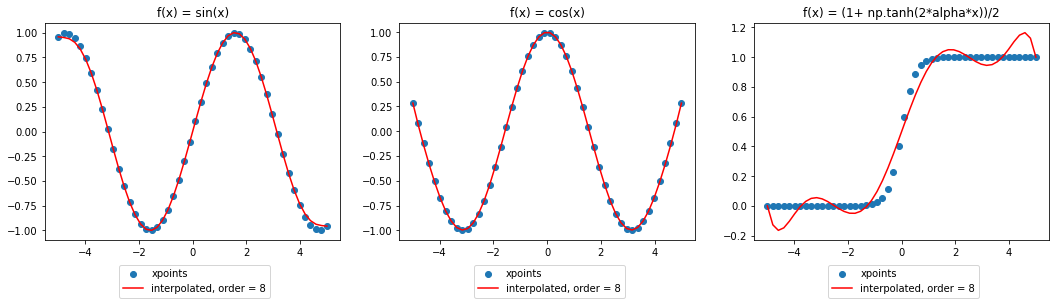

In [6]:
functToUse = lambda x: np.sin(x)
functToUse2 = lambda x: np.cos(x)

alpha = 1
functToUse3 = lambda x: (1+ np.tanh(2*alpha*x))/2

xLeft = -5
xRight = 5
order = 8

xfull, fx, xcoeff = singlepiece(functToUse, xLeft, xRight, order)
xfull, fx2, xcoeff2 = singlepiece(functToUse2, xLeft, xRight, order)
xfull, fx3, xcoeff3 = singlepiece(functToUse3, xLeft, xRight, order)

# PLOT RESULTS
fig, axs = plt.subplots(1,3)
fig.subplots_adjust(wspace=0.2); fig.set_figwidth(18)

axs[0].set_title("f(x) = sin(x)")
axs[0].scatter(xfull,functToUse(xfull),label="xpoints")
axs[0].plot(xfull,fx, "r-",label=f"interpolated, order = {order}")
axs[0].legend(bbox_to_anchor=(0.78, -0.09))

axs[1].set_title("f(x) = cos(x)")
axs[1].scatter(xfull,functToUse2(xfull),label="xpoints")
axs[1].plot(xfull,fx2,"r-", label=f"interpolated, order = {order}")
axs[1].legend(bbox_to_anchor=(0.78, -0.09))

axs[2].set_title("f(x) = (1+ np.tanh(2*alpha*x))/2")
axs[2].scatter(xfull,functToUse3(xfull),label="xpoints")
axs[2].plot(xfull,fx3,"r-", label=f"interpolated, order = {order}")
axs[2].legend(bbox_to_anchor=(0.78, -0.09))

### <font color= "purple">Example Solution:</font>

- The following examples make use of the piecewise interpolator, `piecewiseLagrangian`.

### <font color= "green">Setup:</font>

- xmin = -10
- xmax = 10
- order of interpolation = 8
- number of pieces to split into = 11

Feel free to change the values.

In [7]:
xLeft = -10    # recommended = -10
xRight = 10    # recommended = 10
order = 8      # recommended = 8
pieces = 11    # recommended = 11

# declaring functions
functToUse = lambda x: np.sin(x)
alpha = 1
functToUse2 = lambda x: (1+ np.tanh(2*alpha*x))/2
functToUse3 = lambda x: 3*np.cos(x) + 4*np.sin(x) - (x-2)*(x+1)*(x+2.5)

### <font color= "green">Examples:</font>

$$f_1(x) = \sin(x)$$

$$f_2(x) = \frac{1+ \tanh{(2\alpha x)}}{2}$$

$$f_3(x) = 3\cos{x} + 4\sin{x} -(x-2)(x+1)(x+2.5)$$

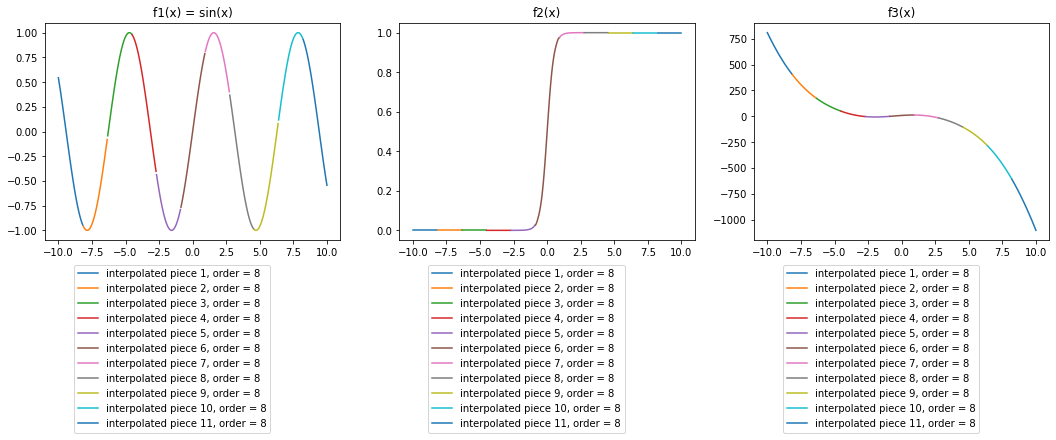

In [8]:
x_master, fx_master, root_master = piecewiseLagrangian(functToUse, xLeft, xRight, order, pieces)
x_master2, fx_master2, root_master2 = piecewiseLagrangian(functToUse2, xLeft, xRight, order, pieces)
x_master3, fx_master3, root_master3 = piecewiseLagrangian(functToUse3, xLeft, xRight, order, pieces)

# PLOT RESULTS
fig, axs = plt.subplots(1,3)
fig.subplots_adjust(wspace=0.2); fig.set_figwidth(18)

# function 1
axs[0].set_title("f1(x) = sin(x)")
for i in range(pieces):
    if i == 0:
        axs[0].plot(x_master[i],fx_master[i], "-",label=f"interpolated piece {i+1}, order = {order}")
    else:
        axs[0].plot(x_master[i][1:],fx_master[i][1:], "-",label=f"interpolated piece {i+1}, order = {order}")
axs[0].legend(bbox_to_anchor=(0.78, -0.09))

# function 2
axs[1].set_title("f2(x)")
for i in range(pieces):
    if i == 0:
        axs[1].plot(x_master2[i],fx_master2[i], "-",label=f"interpolated piece {i+1}, order = {order}")
    else:
        axs[1].plot(x_master2[i][1:],fx_master2[i][1:], "-",label=f"interpolated piece {i+1}, order = {order}")
axs[1].legend(bbox_to_anchor=(0.78, -0.09))

# function 3
axs[2].set_title("f3(x)")
for i in range(pieces):
    if i == 0:
        axs[2].plot(x_master3[i],fx_master3[i], "-",label=f"interpolated piece {i+1}, order = {order}")
    else:
        axs[2].plot(x_master3[i][1:],fx_master3[i][1:], "-",label=f"interpolated piece {i+1}, order = {order}")
axs[2].legend(bbox_to_anchor=(0.78, -0.09))

## Part 2: Polynomial root finding

Now that you have the piecewise interpolator, you can find the roots of the interpolant, instead of the original expensive function. Finding roots of a polynomial is much easier than finding roots of a generic expensive function.

The problem is: we know where the roots of a polynomial of degree 2 are, and even degree 3, but we do not have a formula for higher degrees. 

It turns out it is not very difficult: we just need to construct a specific matrix and find its eigenvalues.
See https://en.wikipedia.org/wiki/Companion_matrix

Implement a function that, given the coefficients and the degree of a polynomial, returns the roots.

### find roots of polynomial using companion matrix.

The companion matrix of a polynomial $p$ is in the form:

$$C(p)=\begin{bmatrix}
0 & 0 & \dots & 0 & -c_0 \\
1 & 0 & \dots & 0 & -c_1 \\
0 & 1 & \dots & 0 & -c_2 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \dots & 1 & -c_{n-1}
\end{bmatrix}$$

The eigenvalues of the companion matrix are the roots of the polynomial.

### <font color= "red">Solution to Part 2:</font>
- The below function is my solution to Part 2, the root finding function
- `getroots`: This function takes in the coefficients of the polynomial (can be computed in part 1) and the degree (order) of the polynomial. First, if the coefficient of the highest order term is 0, it will return an error. So, it truncates the coefficient array until the highest order coefficient is not 0, then adjusts the degree of the polynomial accordingly. Then, it divides the coefficients by the coefficient of the highest order x, so that the coefficient of the highest order x is 1.0, builds the companion matrix and finds the eigenvalues of the matrix. It checks for and discards any duplicate roots, and returns only the real roots.

In [9]:
def getroots(coeffs,degree):
    
    # check that highest order coefficient is not 0
    stop = False
    while stop == False:
        if coeffs[-1] == 0:
            coeffs = coeffs[:-1]
            degree = degree - 1
        else:
            stop = True
    
    c = coeffs/coeffs[-1]
    
    # build companion matrix
    mat = []
    
    for i in range(degree):
        elem = c[i]*-1
        row = np.zeros(degree)
        row[-1] = elem
        if i > 0:
            row[i-1] = 1.0
        mat.append(row)
        
    cmat = np.array(mat)
    
    # get roots
    e = np.linalg.eigvals(cmat)
    
    # return only real roots
    e = [n.real for n in e if n.imag == 0.0]
    
    return np.unique(e)

### <font color="blue">Preliminary tests.</font>

- find roots of some random polynomials

### testing random polynomials.

$$p_1(x) = 24 - 10x - 3x^2 + x^3$$

$$p_2(x) = 24 + 14x - 13x^2 - 2x^3 + x^4$$

$$p_3(x) = 9 + 1.5x - 12.5x^2 - 2.5x^3 + 3.5x^4 + x^5$$

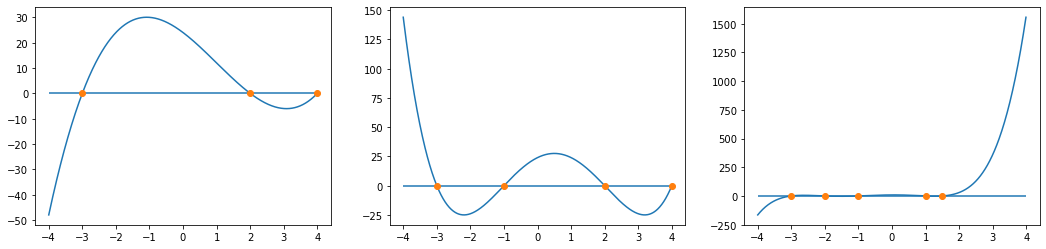

In [10]:
# PLOT FUNCTIONS

poly1 = lambda x: 24 - 10*x - 3*(x**2) + (x**3)
poly2 = lambda x: 24 + 14*x - 13*(x**2) - 2*(x**3) + (x**4)
poly3 = lambda x: 9 + 1.5*x - 12.5*(x**2) - 2.5*(x**3) + 3.5*(x**4) + (x**5)
xrange = np.arange(-4,4,0.01)

fig, axs = plt.subplots(1,3)
fig.subplots_adjust(wspace=0.2); fig.set_figwidth(18)
axs[0].plot(xrange,poly1(xrange))
axs[0].hlines(0,-4,4)
axs[1].plot(xrange,poly2(xrange))
axs[1].hlines(0,-4,4)
axs[2].plot(xrange,poly3(xrange))
axs[2].hlines(0,-4,4)

# SOLVE FOR ROOTS

c1 = np.array([24,-10,-3,1.0])
c2 = np.array([24,14,-13,-2,1.0])
c3 = np.array([9,1.5,-12.5,-2.5,3.5,1.0])

r1 = getroots(c1,3)
r2 = getroots(c2,4)
r3 = getroots(c3,5)

axs[0].plot(r1,np.zeros(len(r1)),"o")
axs[1].plot(r2,np.zeros(len(r2)),"o")
axs[2].plot(r3,np.zeros(len(r3)),"o")

#### notes:
- function works, roots are correct

### <font color= "purple">Example Solution:</font>

- The following example makes use of the polynomial root finding function, `getroots`.
- The coefficients of the polynomials are computed by Lagrangian interpolation, with the function from part 1, `singlepiece`.
- Example functions used are:

$$f_1(x) = \sin(x)$$

$$f_2(x) = 3\cos{x} + 4\sin{x} -(x-2)(x+1)(x+2.5)$$

$$f_3(x) = \frac{1+ \tanh{(2\alpha x)}}{2}$$

### <font color= "green">Setup:</font>

- xmin = -6
- xmax = 6
- order of interpolation = 12

Feel free to change the values.

In [11]:
xLeft = -6    # recommended = -6
xRight = 6    # recommended = 6
order = 12    # recommended = 12

# declaring functions
functToUse = lambda x: np.sin(x)
functToUse2 = lambda x: 3*np.cos(x) + 4*np.sin(x) - (x-2)*(x+1)*(x+2.5)
alpha = 1
functToUse3 = lambda x: (1+ np.tanh(2*alpha*x))/2

### <font color= "green">Examples:</font>

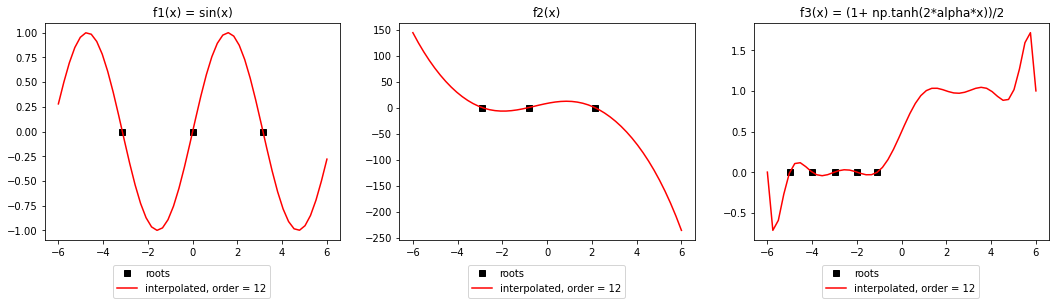

In [12]:
xfull, fx, xcoeff = singlepiece(functToUse, xLeft, xRight, order)
xfull, fx2, xcoeff2 = singlepiece(functToUse2, xLeft, xRight, order)
xfull, fx3, xcoeff3 = singlepiece(functToUse3, xLeft, xRight, order)

# find roots
roots = getroots(xcoeff,order)
roots2 = getroots(xcoeff2,order)
roots3 = getroots(xcoeff3,order)
    
# return only roots in given range
roots = [n for n in roots if n >= xLeft if n <= xRight]
roots2 = [n for n in roots2 if n >= xLeft if n <= xRight]
roots3 = [n for n in roots3 if n >= xLeft if n <= xRight]

# PLOT RESULTS
fig, axs = plt.subplots(1,3)
fig.subplots_adjust(wspace=0.2); fig.set_figwidth(18)

# f1
axs[0].set_title("f1(x) = sin(x)")
axs[0].plot(roots,np.zeros(len(roots)),"ks", label="roots")
axs[0].plot(xfull,fx, "r-",label=f"interpolated, order = {order}")
axs[0].legend(bbox_to_anchor=(0.78, -0.09))

# f2
axs[1].set_title("f2(x)")
axs[1].plot(roots2,np.zeros(len(roots2)),"ks", label="roots")
axs[1].plot(xfull,fx2,"r-", label=f"interpolated, order = {order}")
axs[1].legend(bbox_to_anchor=(0.78, -0.09))

# f3
axs[2].set_title("f3(x) = (1+ np.tanh(2*alpha*x))/2")
axs[2].plot(roots3,np.zeros(len(roots3)),"ks", label="roots")
axs[2].plot(xfull,fx3,"r-", label=f"interpolated, order = {order}")
axs[2].legend(bbox_to_anchor=(0.78, -0.09))

## Part 3: Roots of the piece-wise Lagrangian Interpolation

Now write a function that takes the interpolant and returns all the roots.

### function that returns roots of a given function to interpolate.

- Combines the solutions from part 1 and part 2: `piecewiseLagrangian` and `getroots`

### <font color= "red">Solution to Part 3:</font>
- The below function is my solution to Part 3, the root finding function for the piecewise interpolator.
- `piecewiseroots`: This function takes in the function we want to interpolate, xmin, xmax, the order of interpolation and the number of pieces we want to split the function into. Within, it performs piecewise Lagrangian interpolation (with the solution from part 1), then finds the roots of each interpolated piece (with solution from part 2) recursively. It also checks for and discards roots that are out of range for each piece. Finally, the roots are collected into one master array using list comprehension. It returns the result of the interpolation and all the roots in the total x range.

In [13]:
def piecewiseroots(functToUse, xLeft, xRight, order, pieces):
    
    x_master, fx_master, xcoeff_master = piecewiseLagrangian(functToUse, xLeft, xRight, order, pieces)
    
    # find roots for each piece within the subrange
    root_master = []
    for i in range(pieces):
        xrange = x_master[i]
        subroot = getroots(xcoeff_master[i],order)
        subroot = [n for n in subroot if n >= xrange[0] if n <= xrange[-1]]
        root_master.append(subroot)
    root_master = [r for subr in root_master for r in subr]
    
    return x_master, fx_master, np.unique(root_master)
    # return np.unique(root_master)     # <--- comment out above line and uncomment this if only roots wanted

### <font color= "purple">Example Solution:</font>

- The following example makes use of the piecewise root finding function, `piecewiseroots`.
- The function in the example used is:

$$f_1(x) = \sin(x)$$

$$f_2(x) = 3\cos{x} + 4\sin{x} -(x-2)(x+1)(x+2.5)$$

$$f_3(x) = \frac{1+ \tanh{(2\alpha x)}}{2}$$

### <font color= "green">Setup:</font>

- xmin = -10
- xmax = 10
- order of interpolation = 8
- number of pieces to split into = 7

Feel free to change the values.

In [14]:
xLeft = -10    # recommended = -10
xRight = 10    # recommended = 10
order = 8      # recommended = 8
pieces = 7     # recommended = 7

# declaring functions
functToUse = lambda x: np.sin(x)
functToUse2 = lambda x: 3*np.cos(x) + 4*np.sin(x) - (x-2)*(x+1)*(x+2.5)
alpha = 1
functToUse3 = lambda x: (1+ np.tanh(2*alpha*x))/2

### <font color= "green">Examples:</font>

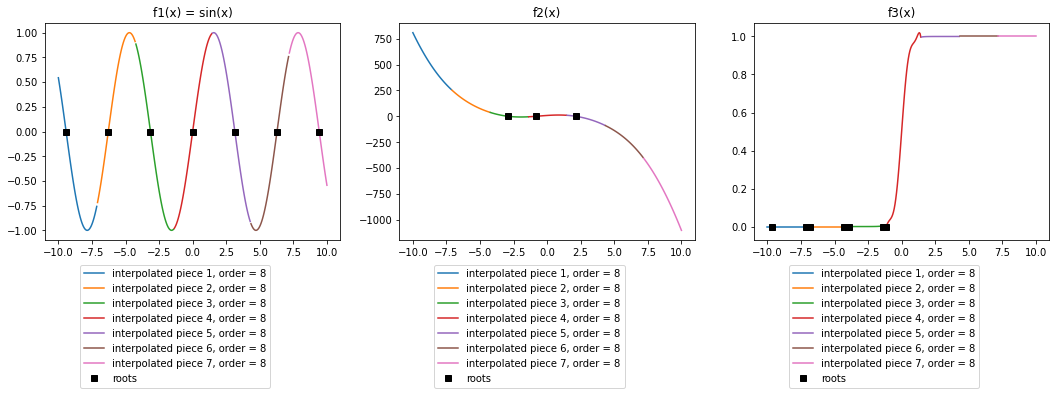

In [15]:
x_master, fx_master, root_master = piecewiseroots(functToUse, xLeft, xRight, order, pieces)
x_master2, fx_master2, root_master2 = piecewiseroots(functToUse2, xLeft, xRight, order, pieces)
x_master3, fx_master3, root_master3 = piecewiseroots(functToUse3, xLeft, xRight, order, pieces)

# PLOT RESULTS
fig, axs = plt.subplots(1,3)
fig.subplots_adjust(wspace=0.2); fig.set_figwidth(18)

# function 1
axs[0].set_title("f1(x) = sin(x)")
for i in range(pieces):
    if i == 0:
        axs[0].plot(x_master[i],fx_master[i], "-",label=f"interpolated piece {i+1}, order = {order}")
    else:
        axs[0].plot(x_master[i][1:],fx_master[i][1:], "-",label=f"interpolated piece {i+1}, order = {order}")

axs[0].plot(root_master,np.zeros(len(root_master)), "ks", label=f"roots")
axs[0].legend(bbox_to_anchor=(0.78, -0.09))

# function 2
axs[1].set_title("f2(x)")
for i in range(pieces):
    if i == 0:
        axs[1].plot(x_master2[i],fx_master2[i], "-",label=f"interpolated piece {i+1}, order = {order}")
    else:
        axs[1].plot(x_master2[i][1:],fx_master2[i][1:], "-",label=f"interpolated piece {i+1}, order = {order}")

axs[1].plot(root_master2,np.zeros(len(root_master2)), "ks", label=f"roots")
axs[1].legend(bbox_to_anchor=(0.78, -0.09))

# function 3
axs[2].set_title("f3(x)")
for i in range(pieces):
    if i == 0:
        axs[2].plot(x_master3[i],fx_master3[i], "-",label=f"interpolated piece {i+1}, order = {order}")
    else:
        axs[2].plot(x_master3[i][1:],fx_master3[i][1:], "-",label=f"interpolated piece {i+1}, order = {order}")

axs[2].plot(root_master3,np.zeros(len(root_master3)), "ks", label=f"roots")
axs[2].legend(bbox_to_anchor=(0.78, -0.09))

## <font color="purple">Concluding thoughts</font>:
- Overall, the solutions work, and the parameter values I recommended in the examples return acceptable results
- Some things could be done better, for example, I tend to use quite a bit of recursion and loops because they are more intuitive to me and I can better visualize the code that way.